# Reproducing Leslie N. Smith's papers using fastai
The following papers by [Leslie N. Smith](https://arxiv.org/search/cs?searchtype=author&query=Smith%2C+L+N) are covered in this notebook :- 
1. A disciplined approach to neural network hyper-parameters: Part 1 -- learning rate, batch size, momentum, and weight decay. [paper](https://arxiv.org/abs/1803.09820)
2. Super-Convergence: Very Fast Training of Neural Networks Using Learning Rates. [paper](https://arxiv.org/abs/1708.07120)
3. Exploring loss function topology with cyclical learning rates. [paper](https://arxiv.org/abs/1702.04283)
4. Cyclical Learning Rates for Training Neural Networks. [paper](https://arxiv.org/abs/1506.01186)

Although, the main aim is to reproduce the papers but a lot of research has been done since than and thus where needed I would change some things to match the state of the art practices. Most of these things are taught in the fastai courses, namely [Practical Deep Learning for Coders, v3](https://course.fast.ai/). 

If you are not familiar with [fastai](https://docs.fast.ai/), it is a deep learning library build on top of PyTorch and it contains the implementations of most of the state of the art practices, which keep changing over time. As a result of this you can get state of the art results in most of the tasks by using the defaults of the library.

**How this notebook is structured.** I would explain all the concepts discussed in the paper and would provide a walkthrough with a CIFAR-100 example along the way. So there would be explanation of the topic and then the code for that. If you are to use these techniques for your own work, you can follow along the notebook from top-to-bottom. For the implementations of some concepts, I would use the fastai built in functions as fastai provides a callback system that really helps a lot when working on projects in real life. So if you do not know fastai, you can watch the course mentioned above or read the docs, as the docs contains ample examples. For Tensorflow users, as of now I am not aware if some library provides this much functionality as fastai but you can still follow on as the concepts discussed are general, only the implementation is different.

If you are learning fastai, this notebook can be a very good tutorial on how to use the vision API in fastai.

## Table of Contents:
1. Summary of hyper-parameters
2. Hyper-params not discussed
3. Things to remember
4. Underfitting vs Overfitting
5. Deep Dive into Underfitting and Overfitting
    1. Underfitting
    2. Overfitting
6. Choosing Learning Rate
    1. Cyclic Learning Rate (CLR) and Learning Rate Test
    2. ResNet-56
    3. Cyclic Learning Rate
    4. Difference from Original paper
    5. One-cycle policy summary
    6. Learning rate finder test
7. Introducing Super-Convergence
    1. Testing Linear Interpolation tests
    2. How it was found in the first place?
    3. Coding Linear INterpolation
8. Explanation behind Super-Convergence

In [1]:
# fastai imports most of the things that you need like numpy
# and much more, so no need to import them again in our work.
from fastai import *
from fastai.vision import *

Although deep learning has produced dazzling successes for applications of image, speech and video processing in the past few years, most trainings are done with suboptimal hyper-parameters, requiring unnecessarily long training times. Setting the hyperparameters reamains a black art that requires years of experience to acquire. So I present several efficient ways to set the hyper-parameters that significantly reduce the training time and improves performance. Specifically, we examine the training and validation/test loss for subtle clues of underfitting and overfitting and suggest guidelines for moving toward the optimal balance point.

**Note: Should I use hyper-parameter tuning library?** I asked this question on the fastai [forums](https://forums.fast.ai/t/what-is-the-de-facto-library-to-use-as-black-box-for-hyperparameter-tuning/44338) and Jeremy replied, "I would suggest avoiding black-box hyperparam tuning wherever possible. I've only used it once in my life, and even then it wasen't really a win. Instead, use the techniqeus we've learned to try carefully selected choices."

And I agree with that. Most of the times there is not much need to use these libraries and as we would soon find that most of the hyper-parameters are linked with each other, so we should tune them accordingly. An argument can be made for Bayesian Optimizations, but I have not used them and I find the techniques discussed here much simpler and safer.

## Summary of hyper-parameters
* **Learning rate** :- Use learning rate finder test and get the maximum value of learning rate that you would use in the 1cycle policy.
* **Batch size** :- The largest value that fits on your GPU. You can use batch sizes like 20 that are not powers of two. The performance drop that is discussed when using batch size that are not powers of 2 is true, but we can ignore it if we want.
* **Momentum** :- 
* **Weight Decay** :- 

### Hyper-params not discussed
* Architecture
* Regularization
* Dataset
* Task

## Things to remember
1. Setting hyperparameters is very important. Every dataset would have their own set of hyperparameter values, and setting the right hyper-parameter values should be your only priority I would say initially.
2. Regularization vs weight decay. In regularization we subtract something from the loss function, while in weight decay we subtract something from the parameter update step.
3. When we use modern architectures like Resnet it is better to use weight decay than L2 regularization.
4. You can set all your hyper-parameters in a few epochs.

## Underfitting vs Overfitting
The basis of this notebook is based on the concept of underfitting vsersus overfitting. Specifically, it consists of examining the training's test/validation loss for clues of underfitting and overfitting in order to strive for the optimal set of hyper-parameters. By observing and understanding the clues available early during training, we can tune our architecture and hyper-parameters with short runs of a few epochs. In particular, by monitoring validation/test loss early in the training, enough information is available to tune the architecture and hyper-parameters and this eliminates the necessity of running complete grid or random searches.

One key finding in the paper is that the total regularization needs to be in balance for a given dataset and architecture. And it was found that learning rate, momentum and regularization are tightly coupled and optimal values must be determined together. This means that if you set a learning rate as a large value than other regularizations like momentum must come down, so that the total remains preserved.

<img src='Extra/under-overfitting.png' width='500'>
<center>Fig 1: The figure shows the optimal capacity that falls between underfitting and underfitting</center>

<img src='Extra/testLoss1.png' width='600'> | <img src='Extra/overfit.png' width='600'>
- | -
Fig2(a) See the top-left corner. You can see a similar bump as was shown in Fig1. This is an early sign of overfitting. | Fig2(b)The overfitting can be see around 3500 where our valid loss starts becoming worse

<center>Fig 2: Figure showing on how you can detect early signs of overfitting when working on your data

An important thing to see here is in some cases like that shown in Fig2(a) where you see that early overfitting but after that your test loss still decreases a little. This can be misleading in some cases where one can get blindsided by reduction in the amoung of test loss. **So draw your losses and see whether you overfit or not.** You should not use a model that overfit early as after that point you can consider your model just learning some examples to reduce test loss, which results in poor generalization.

## Deep Dive into Underfitting and Overfitting

### Underfitting
Underfitting is when the machine learning model is unable to reduce the error for either the test or training set, which is due to the *under capacity* of the machine learning model i.e. it is now pwerful enough to fit the underlying complexities of the data distributions. **Whenever your valid loss is less than the training loss than it means your model is underfitting.**

<img src='Extra/3layerLoss.png' > | <img src='Extra/imagenetTestLoss3.png' >
- | -

<center>Fig 3: Underfitting is characterized by a continously decreasing test loss, rather than a horizontal plateau.</center>

### Overfitting
Overfitting is when your model is too powerful, such that the model starts fitting the training set too well. Using small learning rates can exhibit some overfitting behaviour (as shown in Fig2(a))

<img src='Extra/overfitting3.png' width='600'> | <img src='Extra/imagenetResnetOverfitting.png' width='600'>
- | -
Fig4(a): When using WD=1e-4, the loss reaches a minimum near lr=0.002, then begins to increase displaying overfitting. For WD=4e-3, the loss is stable over a large range of values and attains a lower loss value, indicating that the later WD value is superior to the former | Fig4(b): While the blue curve shows underfiting as the loss keeps decreasing while the red curve shows overfiting where the loss first decreased and then increased.

<center>Fig 4: Increasing validation/test loss indicates overfitting. In fig (a) the sharp increase in loss for yellow curve near lr=0.005 is not a sign of overfitting but is caused by instabilities in the training due to high learning rate.

## Choosing Learning Rate
If the learning rate is too small overfitting can occur. Large learning rates help to regularize the training but if the learning rate is too large, the training will diverge. Hence a grid search of short runs to find learning rates that converge or diverge is possible but there is an easier way.

By training with high learning rates we can reach a model that gets 93% accuracy in 70 epochs which is less than 7k iterations (as opposed to the 6rk iterations which made roughly 360 epochs in the original paper of Resnet).

### Cyclical Learning Rates(CLR) and learning rate test
As a motivation for using this approach see the below figure, just how fast we can get the state of the art results is shown. The reasoning for this is discussed in the next topic.

<img src='Extra/cifar_LR.jpg'>

[Sylvain Gugger](https://sgugger.github.io/) has written two very good blog posts explaining this topic, so I would recommend you to read those first.
* How Do You Find A Good Learning Rate [link](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)
* The 1cycle policy [link](https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy)

Here I just summarize the topic with important details, for a detailed overview refer to the above two links.

In [2]:
# Load CIFAR-100 data. To downlaod the data refer to this link
# https://course.fast.ai/datasets.


# 'Path' is a python package which makes working with directory
# names a lot easier, to import it use `from pathlib import Path`
path = Path('/home/kushaj/Desktop/Data/cifar100/')
path.ls()

[PosixPath('/home/kushaj/Desktop/Data/cifar100/test'),
 PosixPath('/home/kushaj/Desktop/Data/cifar100/models'),
 PosixPath('/home/kushaj/Desktop/Data/cifar100/train')]

In [3]:
# Both test and train folder contains images in the Imagenet format
# where every image is placed in a folder with the same name as the
# class of the image.

In [4]:
# Create a databunch
src = (ImageList.from_folder(path)
                 .split_by_folder(valid='test')
                 .label_from_folder())

In [5]:
data = (src.transform(get_transforms(), size=(32,32))
           .databunch(bs=256, val_bs=512, num_workers=8)
           .normalize(cifar_stats))
        
cifar_stats

([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])

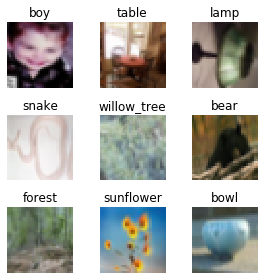

In [6]:
data.show_batch(rows=3, figsize=(4,4))

After creating the databunch we have done the following things
* Added data augmentation with the following [transforms](https://docs.fast.ai/vision.transform.html#get_transforms) and the size of images is taken as (32,32)
* Normalied the images with the CIFAR_STATS
* I am using a batch size of 256 for both trian and valid sets

### Resnet-56
The reason I am not using the original resnet models is due the two downsampling layers in the starting of the resnet model, namely conv and max_pool. If we use these layers than our image size is reduced to 8x8 after just two layers.

So Resnet-56 was also used in the orginal papers and in genral it is a good model for small size images.

In [6]:
# Extra Classes for the head of our model
class AdaptiveConcatPool2d(nn.Module):
    "Layer that concats `AdaptiveAvgPool2d` and `AdaptiveMaxPool2d`."
    def __init__(self, sz=None):
        "Output will be 2*sz or 2 if sz is None"
        super().__init__()
        self.output_size = sz or 1
        self.ap = nn.AdaptiveAvgPool2d(self.output_size)
        self.mp = nn.AdaptiveMaxPool2d(self.output_size)
    def forward(self, x): 
        return torch.cat([self.mp(x), self.ap(x)], 1)

class Flatten(nn.Module):
    "Flatten `x` to a single dimension, often used at the end of a model. `full` for rank-1 tensor"
    def __init__(self, full:bool=False):
        super().__init__()
        self.full = full
    def forward(self, x):
        return x.view(-1) if self.full else x.view(x.size(0), -1)

class BasicBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(c_out)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(c_out)
        
        if stride != 1 or c_in != c_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(c_out)
            )
        
    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += shortcut
        return F.relu(out)
        
        
class Resnet(nn.Module):
    def __init__(self, num_blocks=[9,9,9], num_classes=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group(32, 64, num_blocks[2], stride=2)

        self.head = nn.Sequential(
            AdaptiveConcatPool2d(),
            Flatten(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(128, 128, bias=True),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes, bias=True)
        )
        
    def make_group(self, c_in, c_out, num_blocks, stride):
        layers = [BasicBlock(c_in, c_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(c_out, c_out, stride=1))
        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.head(out)
        return out

In [10]:
learn = Learner(data, Resnet(), metrics=[accuracy, top_k_accuracy], callback_fns=[ShowGraph])

Till now we have done the following:
* Fot out data, which is stored in `data` as a databunch
* A Resnet model is created
* A `learner` object is created which is names `learn`
* AdamW is used as the optimization function
* CrossEntropyLoss is used as loss function

### Cyclic Learning Rate
The essence of this learning rate policy comes from the observation that increasing the learning rate might have a short term negative effect and yet achieve a longer term beneficial. So we vary our learning rate from a small value to large value than back to small value. This is termed as one complete cycle.

<img src='Extra/triangularWindow.png'>

This learning rate policy is taken from the original paper, but that was few years back. Now we use a cosine policy that lookes something like this.

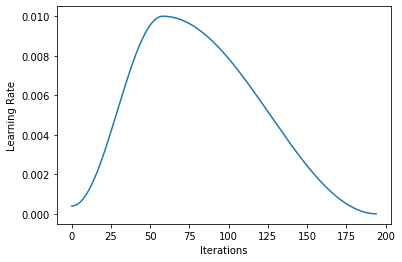

In [18]:
# Skip the code for now
learn.fit_one_cycle(1, max_lr=1e-2)
learn.recorder.plot_lr()

If you have any question on why is the learning rate policy defined as this or in general to the learning rate policy in fastai, I have answered all the questions in the forums which you can check [here](https://forums.fast.ai/t/shedding-some-light-about-lr-management-in-fastai/43708). There I clearly explain why we use a learning rate policy that looks like the one shown above and what are the reasons behind choosing the deafults. (The main reason is we want to train our model at higher learning rates and then fine-tune them at lower learning rates).

For the implementation of this, you can check [this](https://github.com/KushajveerSingh/fastai_without_fastai) where I implement the one-cycle policy in pure pytorch.

### Difference from original paper
There are some changes that you would notice from the original paper. First, in the papers for most of the cases accuracy is used as the metric for most of the graphs, while I use loss values. The reason loss values are used to compare hyper-parameter value is loss is the actual thing that is being optimized we want to reduce it the most.

### One-cycle policy summary
There are two phases, first learning rate increases from small lr to maximum value and in the second phase it decreased from the maximum value to the minimum value (the minimum value is smaller than the starting value in the first phase). In implementation, you only need to define the maximum value of the learning rate and the minimum values would be calculated appropriately.

### Learning rate finder test
In order to find the maximum value of leanring rate (max_lr) we using a learning rate test. In this test we start with a small value of learning rate (1e-7) and then increase this value to a maximum of 10 as shown in the figure below.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


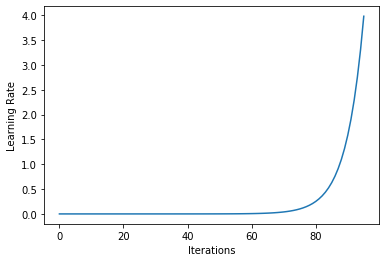

In [20]:
learn.lr_find()
learn.recorder.plot_lr()

In fastai this test can be done using `learn.lr_find`. After running this test we plot a diagram of the loss values for the different values of learning rate and try to find the maximum value of learning rate that we can use.

In [21]:
learn.lr_find(start_lr=1e-7, end_lr=10, num_it=100)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


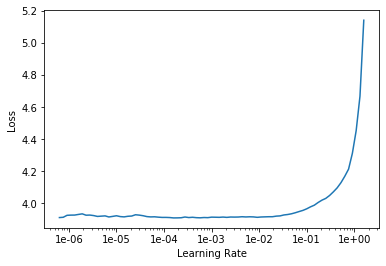

In [22]:
# We plot the loss vs learning rate
learn.recorder.plot()

Now you need to look at the above figure and select the lr value that you want to use. I would use lr=1e-2. The art of selecting good values comes down to practice, just try the values you are confused about and select the one that gives the best results. There are certain guidelines that you should follow while finding the lr value
* Select the one where the loss is small for larger amount of time
* When loss begins to increase, select a value that is 10 times less

For experimentation, let us see what the resutls are when I use max_lr=1e-2 and max_lr=1e-1

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.117561,4.697643,0.047400,0.175600,01:48
1,3.663519,3.413377,0.173200,0.446900,01:47
2,3.335882,3.095275,0.239100,0.529900,01:48


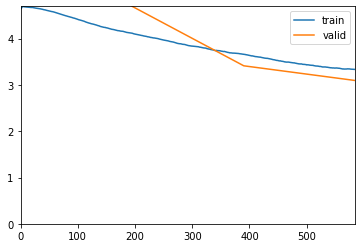

In [24]:
# In fastai there fit_one_cycle function that trains your model using the 1cycle policy
# So you don't have to code up anything
learn = Learner(data, Resnet(), metrics=[accuracy, top_k_accuracy], callback_fns=[ShowGraph])
learn.fit_one_cycle(3, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.334694,4.820587,0.036000,0.156500,01:51
1,3.994016,3.712073,0.109600,0.351700,01:52
2,3.565970,3.270659,0.197700,0.490200,01:46


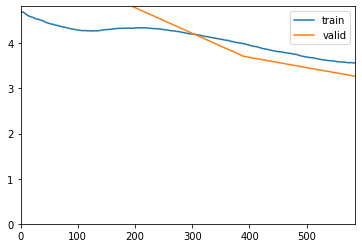

In [25]:
learn = Learner(data, Resnet(), metrics=[accuracy, top_k_accuracy], callback_fns=[ShowGraph])
learn.fit_one_cycle(3, max_lr=1e-1)

As you can see clearly max_lr=1e-2 is better than max_lr=1e-1. Athough this test took around 11 minutes but we easily got the value of lr that we should use. With enough practice you can predict the best value of max_lr from directly the `lr_find` graph but whenever you are confused running some epochs can help.

## Introducing Superconvergence
Now we know what is 1cycle policy and how we can use it for our own work in fastai, next I want to discuss **Superconvergence** which is basically what we are getting using the 1cycle policy.

<img src='Extra/ResNetCifar10Range1.png' width='60%'>

<center>Test accuracy for learning rate range = 0.001 - 1 for ResNet-52, ResNet 56 and ResNet 60</center>

There are two noteworthy things to see in this figure. First is the dip in the accuracy around LR=0.1. Second is the consistently high test accuracy over a large span of learning rates (LR=0.25 to 1.0), which is unusual. Seeing these unsual facts, experiments were carried out using cyclic learning rate and the following counterintuitive things results appeared.

<img src='Extra/Cifar10Resnet56TBS1000CLR35SS10k.png' width='700'> | <img src='Extra/Cifar10Resnet56TBS1000LR35CLR1.png' width='700'>
- | -
(a) Cyclical learning rate between LR=0.1 and LR=0.35 with stepsize=10K | (b) Super-convergence with CLR = 0.1-1.0 versus standard training with initial LR=0.35

<center>Fig: Test accuracies for Resnet-56 on CIFAR-10. Note the log scale used for the vertical axis.

You can see an anomly that occurs as the LR increases from 0.1 to 0.35. The training loss increases sharply by four orders of magnitude at a learning rate of approximately 0.255 but training convergence resumes at larger learning rates. In addition, there are divergenct behaviours between test accuracy and loss curves that are not easily explained.In the first cycle, when the learning rate is increasing from 0.13 to 0.18 the test loss increases but the test accuracy also increases. This simultaneous increase in the test loss and the test accuracy also occurs in the second cycle as the learning rate decrease from 0.35 to 0.1 and in various portions of subsequent cycles.

Another interesting fact can be see from the second figure. The cyclic learning rate method is able to get 0.93 accuracy after just once cycle and it remains the same for the subsequent cycles, while the standard approach of using a constant learning rate manages to achieve the accuracy close to 0.93 at about 5 times more iterations.

### **Superconvergence**
Super-convergence refers to this phenomenon where a network is trained to a better final test accuracy compared to tradional training, but with fewer iterations and a much larger learning rate.

### Testing linear interpolation results
In the *Exploring Loss Function Topology with Cyclical Learning Rates* (only 3 pages) an important topic of networkinterpolation is discussed which shows that the solution found by each cycle is different from each other (intuitively you can think the solutions as belonging to different valleys). So we can interpolate solutions from different cycles and we can except better accuracy. So I test this fact now?

Interpolation between two values is defined as 

<img src='Extra/interpolation.png' width='300'>

### How it was found in the first place?
Before getting into code, I would discuss how this fact was found. So interpolations between different cycle weights was tested and the plots for interpolation were drawn for the train and test loss. One of the figure is shown below

<img src='Extra/test_loss_normalTrainResNet_10k_to_25k_plot.png' width='600'> | <img src='Extra/test_loss_resNet2_40k_to_60k_plot.png' width='600'>
- | -
(a) Training and test loss for interpolation between two network states from regular ResNet training. If both the values are for the same minima than this is what we would get, two concave shapes. | Training and test loss for interpolation between two CLR solutions. If there is a peak between two solutions then the two minimas are different solutions.

<center>Fig: Results of network interpolation for differently trained models</center>

From this plot it was observed that the solution found by each cycle indeed belonged to different minima. Also an addional noteworthy feature, some amount of regularization is possible through interpolating between two solutions. The minima for training loss are at `a=0.0 and 1.0` but the test loss minima are slightly offset towards the center.

### Coding Linear Interpolation
To check the results for the above topic the following things would be done:
1. Do some training epochs on the training dataset and get the weights for diferent cycles
2. Make a plot of interpolation between different weight values

To modify our training loop callbacks would be used. I consifer callbacks to tbe the most important feature of fastai as it allows infinite customization without chaning the training loop.

In [7]:
class GetWeights(Callback):
    def __init__(self, learn, save_list=[5, 7]):
        self.learn = learn
        self.save_list = save_list
        
    def on_train_begin(self, **kwargs):
        self.weights = {}
        
    def on_epoch_end(self, **kwargs):
        if kwargs['epoch'] in self.save_list:
            weights = learn.model.state_dict()
            for k, v in weights.items():
                weights[k] = v.cpu()
            self.weights[kwargs['epoch']] = weights
    
    def get_weights(self):
        return self.weights
        
learn = Learner(data, Resnet(), metrics=[accuracy, top_k_accuracy], callback_fns=ShowGraph)
getWeights = GetWeights(learn)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.191520,4.533091,0.053900,0.195400,01:54
1,3.791083,4.001433,0.102000,0.318300,01:53
2,3.429356,3.574863,0.161400,0.429000,01:50
3,3.125475,3.035374,0.231600,0.533600,01:53
4,2.832539,2.619795,0.312300,0.643800,01:53
5,2.584690,2.346036,0.374700,0.704900,01:53
6,2.407087,2.109318,0.422400,0.756300,01:53
7,2.304121,2.082097,0.429800,0.761200,01:48


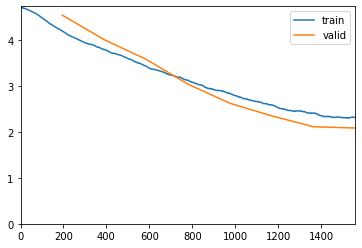

In [8]:
learn.fit_one_cycle(8, max_lr=1e-2, callbacks=getWeights)

In [12]:
weights = getWeights.get_weights()
w1 = weights[5]
w2 = weights[7]

In [13]:
# Just to verify that it worked. The loss value is same as above so it worked
learn.model.load_state_dict(w1)
learn.validate()

[2.3460364, tensor(0.3747), tensor(0.7049)]

In [14]:
# Do interpolation
def interpolate(alpha):
    w_new = {}
    keys = list(w1.keys())
    for key in keys:
        w_new[key] = alpha*w1[key] + (1 - alpha)*w2[key]
    return w_new

In [15]:
alpha_range = np.linspace(start=-0.5, stop=1.5, num=100)
train_loss = []
val_loss = []
for i, alpha in enumerate(alpha_range):
    print(f'{i}/{len(alpha_range)} started')
    w_new = interpolate(alpha)
    learn.model.load_state_dict(w_new)
    loss1, _, _ = learn.validate()
    loss2, _, _ = learn.validate(data.train_dl)

    val_loss.append(loss1)
    train_loss.append(loss2)

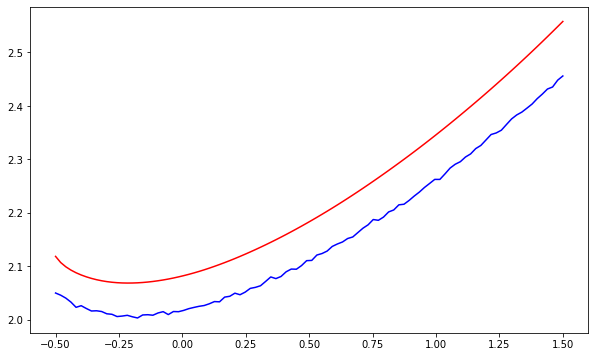

In [22]:
plt.figure(figsize=(10,6))
plt.plot(alpha_range, train_loss, 'b')
plt.plot(alpha_range, val_loss, 'r')
plt.show()

In [23]:
alpha_range = np.linspace(start=-10, stop=4, num=50)
train_loss2 = []
val_loss2 = []
for i, alpha in enumerate(alpha_range):
    print(f'{i}/{len(alpha_range)} started')
    w_new = interpolate(alpha)
    learn.model.load_state_dict(w_new)
    loss1, _, _ = learn.validate()
    loss2, _, _ = learn.validate(data.train_dl)

    val_loss2.append(loss1)
    train_loss2.append(loss2)

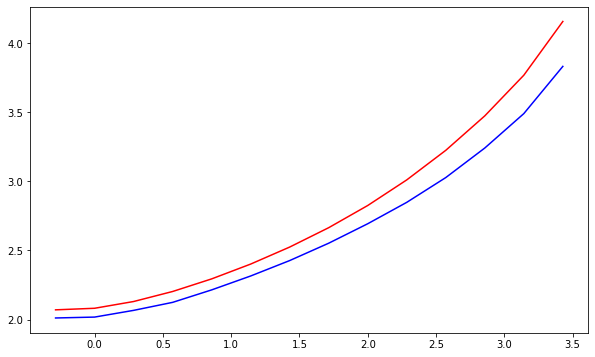

In [29]:
plt.figure(figsize=(10,6))
plt.plot(alpha_range, train_loss2, 'b')
plt.plot(alpha_range, val_loss2, 'r')
plt.show()

Losses went nan for the initial values. Seeing this we cannot combine both of them, but the reason being in the paper SGD was used while here we are using AdamW with cyclic momentum by default so it changes up the situation by a lot. But it is a fun experiment.

## Explanation behind Super-Convergence
As we discussed earlier, one of the indicators of super-convergence are the consistent high value of accuracies with increasing learning rate. Cyclic Learning which allowed super-convergence is indeed a combination of **Curriculm learning** and **simulated annealing**. Also, as the amount of data decreases the gap in performance between the result of standard training and super-convergence increases. Specifically, with a peicewise constant learning rate schedule the training encounters difficulties and diverges along the way.

<img src='Extra/maxout_3d.png' width='85%'> | <img src='Extra/maxout_3d_zoom.png' width='85%'>
- | -
(a) Visualization of how training traverses a loss function topology | (b) A close up of the end of training for figure (a)

<center>The 3-D visualizations from Goodfellow et al. [2014]. The z-axis represents the loss potential.</center>

The above figure gives an intuitive understanding of how super-convergence happens. The blue line in the figure represents the trajectory of the training while converging and the x's indicate the location of the solution at each iteration and indicates the progress made during the training.

The while loss surface can be divided into 3 phases:-
1. In early training, the learning rate must be small in order for the training to make progress in appropriate direction. As you can see in the figure a significant progress is made in those early iterations (the part where we descend the valley)
2. Now as the slope decreases so does the amount of progress made per iteration and little improvement occurs over the bulk of the iteration. This is the reason why we increase the learning rate to high values, so that we can quickly move over this region.
3. As we approach the bottom of the loss surface (you can think of it as bottom of valley with bumps), so here we need to slow down and get to the bottom of these bumps i.e. why we decrease the value of learning rate to minimum value so that we can fine-tune our final result.

### A quick summary
Initially when the learning starts there is huge slope and we move down it quickly, now there is a straight out path and we make very less progress through each iterations. At the end we enter a valley and we have to move towards the minima. Cyclic Learning Rate solves it. We start with small learning rate to get over that initial big slope. Then we increase the learning rate to quickly move through the straight path and then we again decrease learning rate to move through the valley.